In [2]:
# 기본 작업 경로 설정
import os
notebook_path = os.path.abspath("../readme.md")
notebook_dir = os.path.dirname(notebook_path)
os.chdir(notebook_dir)

# 현재 작업 디렉토리 출력
print("Current working directory: ", os.getcwd())

Current working directory:  /mnt/e/py_data/project_3_git


In [3]:
import json

def openjson(path):

    with open(path, encoding="cp949") as f:
        data = json.load(f)
    return data

trainjsons = []
testjsons  = []
validjsons = []

trainjsons.extend([i for i in openjson('data/face_lables/train_label/train_anger.json')])
trainjsons.extend([i for i in openjson('data/face_lables/train_label/train_happy.json')])
trainjsons.extend([i for i in openjson('data/face_lables/train_label/train_panic.json')])
trainjsons.extend([i for i in openjson('data/face_lables/train_label/train_sadness.json')])

validjsons.extend([i for i in openjson('data/face_lables/val_label/val_anger.json')])
validjsons.extend([i for i in openjson('data/face_lables/val_label/val_happy.json')])
validjsons.extend([i for i in openjson('data/face_lables/val_label/val_panic.json')])
validjsons.extend([i for i in openjson('data/face_lables/val_label/val_sadness.json')])

testjsons.extend([i for i in openjson('data/face_lables/test_label/test_anger.json')])
testjsons.extend([i for i in openjson('data/face_lables/test_label/test_happy.json')])
testjsons.extend([i for i in openjson('data/face_lables/test_label/test_panic.json')])
testjsons.extend([i for i in openjson('data/face_lables/test_label/test_sadness.json')])

# RCNN 및 SSD 어노테이션

In [4]:
# json 에서 파일 이름과 박스 및 라벨 가져와 새로정의
emotion_mapping = {0 : '분노', 1 : '슬픔', 2 : '당황', 3 : '기쁨'}
emotion_mapping_reversed = {j: i for i, j in zip(emotion_mapping.keys(), emotion_mapping.values())}


In [5]:

filename_train = []
boxes_train = []
lables_train = []
for i in trainjsons:
    filename_train.append(i['filename'])
    lables_train.append(emotion_mapping_reversed[i['faceExp_uploader']])
    boxes_train.append([ 
        i['annot_A']['boxes']['maxX'], 
        i['annot_A']['boxes']['maxY'], 
        i['annot_A']['boxes']['minX'], 
        i['annot_A']['boxes']['minY']
    ])


filename_valid = []
boxes_valid = []
lables_valid = []
for i in validjsons:
    filename_valid.append(i['filename'])
    lables_valid.append(emotion_mapping_reversed[i['faceExp_uploader']])
    boxes_valid.append([ 
        i['annot_A']['boxes']['maxX'], 
        i['annot_A']['boxes']['maxY'], 
        i['annot_A']['boxes']['minX'], 
        i['annot_A']['boxes']['minY']
    ])

In [6]:
import cv2
import numpy as np

def resize_and_pad_image_and_boxes(image_path, boxes, target_size=(512, 512)):
    # 이미지 로드
    image = cv2.imread(image_path)
    orig_height, orig_width = image.shape[:2]
    
    # 목표 크기
    target_width, target_height = target_size
    
    # 비율 계산
    aspect_ratio = orig_width / orig_height
    target_aspect_ratio = target_width / target_height
    
    if aspect_ratio > target_aspect_ratio:
        # 너비 기준으로 리사이즈
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        # 높이 기준으로 리사이즈
        new_height = target_height
        new_width = int(target_height * aspect_ratio)
    
    # 리사이즈된 이미지 생성
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    
    # 목표 크기의 검은색 배경 이미지 생성
    new_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    # 중앙에 리사이즈된 이미지를 붙히기
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image[paste_y:paste_y + new_height, paste_x:paste_x + new_width] = resized_image
    boxed_image = new_image.copy()
    
    # 박스 좌표 조정
    resized_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        
        # 원본 이미지에서의 상대 위치
        x_min_rel = x_min / orig_width
        y_min_rel = y_min / orig_height
        x_max_rel = x_max / orig_width
        y_max_rel = y_max / orig_height
        
        # 목표 이미지에서의 절대 위치
        x_min_new = int(x_min_rel * new_width + paste_x)
        y_min_new = int(y_min_rel * new_height + paste_y)
        x_max_new = int(x_max_rel * new_width + paste_x)
        y_max_new = int(y_max_rel * new_height + paste_y)
        
        resized_boxes.append([x_min_new, y_min_new, x_max_new, y_max_new])
    
    # 박스 그리기
    for box in resized_boxes:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(boxed_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    return boxed_image, new_image, resized_boxes

[[341, 346, 227, 207]]


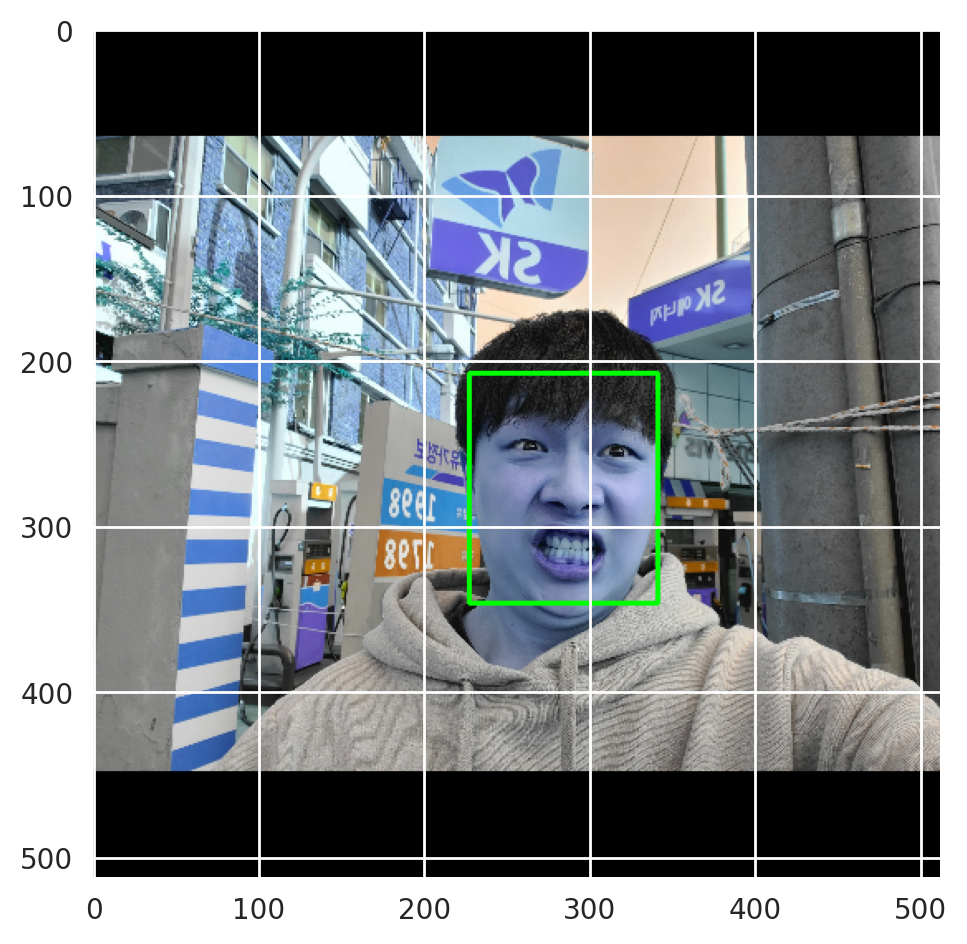

In [7]:

i = 55
# 이미지 경로와 박스 좌표
image_path = f'data/yolo_data/train/{filename_train[i]}'
target_size = (512, 512)

# 이미지 리사이즈, 패딩 및 박스 좌표 조정
padded_image, new_image, resized_boxes = resize_and_pad_image_and_boxes(image_path, [boxes_train[i]], target_size)

# 결과 보기
plt.imshow(padded_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 조정된 박스 좌표 출력
print(resized_boxes)

In [8]:
'data/yolo_data/train'
'data/yolo_data/val'

'data/yolo_data/val'

In [9]:
dataset_train = {}
imgsnp = []
imgslabel = []
imgsboxes = []
for filen, box_, label_ in zip(filename_train, boxes_train, lables_train):
    print(filen,box_,label_)
    # 이미지 리사이즈, 패딩 및 박스 좌표 조정
    try:
        boxed_img, new_image, resized_boxes = resize_and_pad_image_and_boxes(
            'data/yolo_data/train/' + filen,
             [box_], (512, 512))
        imgsnp.append(new_image)
        imgslabel.append([label_])
        imgsboxes.append(resized_boxes)
    except:
        pass

dataset_train['imgs']=imgsnp
dataset_train['labels']=imgslabel
dataset_train['boxes']=imgsboxes

6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63ec1162f5f6bfc6e481l.jpg [2073.2546049999996, 1486.204442, 1338.2201049999999, 539.5066419999999] 0
65rsfe402042f34319e10128c1ab9614e2f967690a64a0016f2c49ff33fe7sy3z.jpg [2889.526926369863, 2306.348256350543, 1812.2228167808219, 711.2784527025274] 0
b1cbe34734870cc11c33334e02bea93ac3a3b061caab62c0df1c6b9c75430tquz.jpg [1950.3801187037307, 1564.586938396402, 1092.9011264243265, 565.4371172958059] 0
llfycc0aa29599cc63cace3610fdaaad3a99aab2ee38c9edb6c10966765bbwd5f.jpg [849.4007, 1153.1373, 156.9877, 289.18299999999994] 0
3hww73b70615461a7336d0383b53582f8bf804f6e0f30d64f36fb410038b82m2u.jpg [1402.8889, 1383.8163000000002, 614.3515, 295.55908] 0
6djf1d1227b4cee1da85978242a51039128237521375765184125912377b5f47y.jpg [1841.4105, 1807.9999999999998, 606.84296, 282.14148] 0
4fsc41eceaf74e53b3f34c3adf73cc199d8bd87c8f33a9593d7201353b57173lx.jpg [2446.9465, 1823.0009, 1467.73, 480.9662000000001] 0
29b1d481bb37696f54b4e0bb829dd3aa02be8bfeecd6ead600aa29bf

[ WARN:0@631.740] global loadsave.cpp:241 findDecoder imread_('data/yolo_data/train/xuiz83a96877b841898d16f32a9276e7a8d779d8d68f458e2816e296d6558w6em.jpg'): can't open/read file: check file path/integrity


j4mpb9435cb4031a43b259716479e3405a34256fa41ab22cdda78db93fdd5qpo1.jpg [3104.3623771878956, 1285.6826616743642, 2235.0344387117266, 39.41186365712931] 2
pdao7b7efef2231186a0b1762aba6bd8b9ba6e74fcabc6f3b261fbebeacae4a7h.jpg [2565.2644322244005, 1697.1787327742068, 1585.6629562096402, 601.7637854970004] 2
kxzp7b270fca37f5c742b5637cf92241020e6155267b272b9c754961ff0f9vlne.jpeg [2205.5907207864925, 1953.691952827933, 1385.2401634240346, 762.2657471720669] 2
v2gyf9294cc89f9951832a9dca38572db295a9a29c918e4e19295ef7dcb862etf.jpg [1312.2747, 1380.5014999999999, 606.32495, 488.22107] 2
p8p9b20b2dd1b5bb0a37b7d8a051b3bdfb888b016d991db9037c6df10c900uwhg.jpg [1448.5007, 1048.8214, 830.2071, 191.06373999999997] 2
xuhca66c768aacba5a2f3f7d5a45a50aa6675c82bc1d5334f5415dffd26b6ip7p.jpg [1919.2836992447928, 1640.2474, 1146.3055008498159, 560.2821] 2
8x635452085157ac610696fb55d4ca8db178bd451c74107481dfdfd749b1awhxl.jpg [1854.154368341889, 1443.0003430803376, 1167.9130513209923, 554.1974718331608] 2
ut6i3063

[ WARN:0@883.168] global loadsave.cpp:241 findDecoder imread_('data/yolo_data/train/0xah1dfff2988dd0bb1002299e49a2e81221721df2086792404682f191894jnl2.jpg'): can't open/read file: check file path/integrity


xj79713df63fea27ddc77d36aa5f8017392d00dbd7dbfed0e03f13f71d379yt34.jpg [1793.3592999999998, 1459.5831, 912.5743399999999, 359.90662] 1
v8zp8d7e487dc8fac1dd4827787c4097940de8c84d6c65c7b55806226c60doham.jpg [2413.5971772503935, 1683.9603999999993, 1493.4463334366294, 371.3109699999997] 1
knxm86156f6a3d082e2112a320d89843026331f5d306a888cafc04c8e8a04da1d.jpg [945.0713, 894.1983000000001, 580.66504, 390.1306] 1
6rata0a7e10a467e70c03cc7f71f1ec0f3e3a170781117a2fc3349b781e47oglu.jpg [1574.5149, 1703.0452999999998, 793.597, 653.841] 1
e3pz668b5d6a856bd55f964f265b6d955b535d528c2524f6d96f6cc72cb6cinp8.jpg [1420.5259538226996, 832.3690000000001, 895.8708133528734, 141.57895000000013] 1
8l225319591e413751572004f7d9a0d334d2c8f836ca133fd0b343e393c23ms50.jpg [1460.4390999999998, 1288.8575000000003, 905.1128499999999, 557.4459] 1
9ab6b9e3f992235b29832b938ce6326b855cdbc306cbad3f59f539c5353c3dr7x.jpg [2301.5007954753864, 1870.985163236579, 1638.367668908174, 942.1617536645688] 1
ctgw36fbfaf0d25a33dfaedfdf

In [10]:

dataset_valid = {}
imgsnp = []
imgslabel = []
imgsboxes = []
for filen, box_, label_ in zip(filename_valid, boxes_valid, lables_valid):
    print(filen,box_,label_)
    # 이미지 리사이즈, 패딩 및 박스 좌표 조정
    try:
        boxed_img, new_image, resized_boxes = resize_and_pad_image_and_boxes(
            'data/yolo_data/val/' + filen,
             [box_], (512, 512))
        imgsnp.append(new_image)
        imgslabel.append([label_])
        imgsboxes.append(resized_boxes)
    except:
        pass

dataset_valid['imgs']=imgsnp
dataset_valid['labels']=imgslabel
dataset_valid['boxes']=imgsboxes

7uji1c8ab7778bc286c3cd90077847f9a906f00b210838ba57877a29abd60ffix.jpg [2333.6550000000007, 1321.8902999999998, 1635.0129999999997, 333.64478] 0
qokw201acdd0f74c7794a9ddcbc9cabdf9c79dd711cbed27d0cd91a20bf19z1bj.jpg [1697.4208984198463, 1640.0318055933903, 963.5640594589413, 708.0750459217618] 0
tzg8926848c43051598de35ece59588857ce02af1699541b88484a1bede3ev7xl.jpg [2078.5635, 1241.8509999999999, 1171.624, 0.33461759999998886] 0
w4vh9e941e6c400f03df009496eaa1f639e73d8ec8104c171d67416108553j55a.jpg [1921.7761, 1827.1334, 889.97974, 531.4823] 0
qii07233b67c5d41cb109e19d2d14309cb177b43f40698d3f422d470280619go4.jpg [2855.2921759814267, 2190.1128084119105, 1905.4111552516085, 997.1763274974619] 0
1jc366caa6eb485bb2d566bb8688f7bb72492b26894627bc3d4fb5a4633bb5ck1.jpg [1632.4968687409557, 1365.617485618003, 789.2969687409555, 235.13658561800287] 0
xwb02a760e19d20284187de8a2c77625d5b1c31d814473bb4042c0ae64e44hm1m.jpg [1924.074, 1497.8119, 1010.7824000000002, 271.65222] 0
cnf9362119c28f311c8a74a3f9

[ WARN:0@1292.610] global loadsave.cpp:241 findDecoder imread_('data/yolo_data/val/txtsa05b8c80e028f82ee48667c66602eab60a46f0eaeaa73601ae5a59b967n49.jpg'): can't open/read file: check file path/integrity


g47re85b6574be7004e53e6aaeaeefc2e79363b2a942cbe240459239829e22igk.jpg [2575.7199999999993, 1426.7815, 1716.4485999999997, 334.2408] 3
irf9a9aba21a40ee5e0382799ed53e536964b0a67703a166e0da8a69a3783kgye.jpg [2280.1257, 1461.5898, 1506.4951999999998, 451.14014] 3
9h5g1da6785445a3360aba30bae4454a021dfe8f1f6406a012713539728f5bxvc.jpg [2012.2792999999997, 1289.5723, 1336.4805, 456.78524999999996] 3
7sbdb43b215b10a4b050006b1cdbfc6f4da11d9b1fbcdf930ccb0042b08a1831y.jpg [3325.3223, 1457.0116000000003, 2318.87, 147.00722999999996] 3
jgsebbdce6508e96e33bd68edebc0b5c5ab3e5e0c8d0838d8bbcb735c185dz4bz.jpg [1447.5494, 1473.4491000000003, 682.2653, 439.05019999999996] 3
h5ob35c6fc899cc5b55bf198f9af2db2a207b62f4ef5713a1f9757bbd27f1gthr.jpg [1949.4878999999999, 1457.0266551394145, 1050.5405000000003, 130.89079392245668] 3
h9k9bfb21c0e61d5f3dbadbd3b646d6bfb44f36d7e69b8949a4bf11bdbdb88657.jpg [1591.1366458062212, 1232.3102385312447, 933.5956541937788, 313.4011414687555] 3
qwlkdc2df091200d8f1fcea680861f1322

In [11]:
imgslabel

[[0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0]

# ssd, rcnn 데이터셋 제작 완료

In [12]:
import pickle

dataset_train
dataset_valid

with open('data/ssd_rcnn_face/train.json', 'wb') as f:
    pickle.dump(dataset_train, f)

with open('data/ssd_rcnn_face/valid.json', 'wb') as f:
    pickle.dump(dataset_valid, f)

# annotaion for coco (faster rcnn)

In [39]:
import json
import os
from PIL import Image

# 데이터 경로 설정
image_dir = 'data/yolo_data/train/'
annotation_dir = 'data/yolo_data/train/'
output_json_path = 'data/ssd_rcnn_face/annotations.json'


In [40]:

# 카테고리 정의 (실제 클래스 수와 이름에 맞게 수정)
categories = [
    {'id': 1, 'name': 'angry'},
    {'id': 2, 'name': 'sad'},
    {'id': 3, 'name': 'surprised'},
    {'id': 4, 'name': 'happy'},
    # 추가 카테고리
]

In [41]:
# COCO 형식 JSON 구조 초기화
coco_format = {
    'images': [],
    'annotations': [],
    'categories': categories
}

annotation_id = 0
image_id = 0

def read_image_size(image_file):
    with Image.open(image_file) as img:
        return img.size

for image_file in os.listdir(image_dir):
    if not image_file.lower().endswith(('.jpg', '.png')):
        continue

    image_path = os.path.join(image_dir, image_file)
    width, height = read_image_size(image_path)

    # 이미지 메타데이터 추가
    coco_format['images'].append({
        'id': image_id,
        'file_name': image_file,
        'width': width,
        'height': height
    })

    # .txt 파일에서 어노테이션 읽기
    txt_file = image_file.rsplit('.', 1)[0] + '.txt'
    txt_path = os.path.join(annotation_dir, txt_file)

    if not os.path.exists(txt_path):
        continue

    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0]) + 1
            x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

            # YOLO 형식을 COCO 형식으로 변환
            x_min = (x_center - bbox_width / 2) * width
            y_min = (y_center - bbox_height / 2) * height
            bbox_width *= width
            bbox_height *= height

            # COCO 형식으로 변환된 어노테이션 추가
            coco_format['annotations'].append({
                'id': annotation_id,
                'image_id': image_id,
                'category_id': class_id,
                'bbox': [x_min, y_min, bbox_width, bbox_height],
                'area': bbox_width * bbox_height,
                'iscrowd': 0
            })
            annotation_id += 1

    image_id += 1
    if image_id == 100 :
        break
# JSON 파일로 저장
with open(output_json_path, 'w') as f:
    json.dump(coco_format, f, indent=4)


In [42]:
coco_format

{'images': [{'id': 0,
   'file_name': '007b10b45d424e7876e73b6b66d62d603c6ef2ee886761e570b2110e47608iwlr.jpg',
   'width': 3088,
   'height': 1737},
  {'id': 1,
   'file_name': '00ceb5eb09f1ee2f4144cbda7fd5561fb1b0252310231e30b2a55ad3215f1pdd0.jpg',
   'width': 4032,
   'height': 3024},
  {'id': 2,
   'file_name': '00hj57bc2be60739b1b9f99316a3a11de5febe993b093876bb33d7bab900006ts.jpg',
   'width': 3264,
   'height': 1592},
  {'id': 3,
   'file_name': '00skd6f03c1bc8e3f618fb80b7863679bf684363a4d013ad634fab7c647ff8kws.jpg',
   'width': 2576,
   'height': 1932},
  {'id': 4,
   'file_name': '00yucd996df0c12e2dcac91e0a41d77a35181e5ff4cce66ea6cf61f05ec52d9hb.jpg',
   'width': 3088,
   'height': 2320},
  {'id': 5,
   'file_name': '013320f6c6aa0752eb2933111106c9bcbfaaf62b4168626b0a1f3288836bf1n3l.jpg',
   'width': 2944,
   'height': 2208},
  {'id': 6,
   'file_name': '017p7f75ed075e0d375c15f5033600b9d6963fc030ff9b6f613589600678d6mwv.jpg',
   'width': 3088,
   'height': 2320},
  {'id': 7,
   'f